# Ridge Regression
Do one-hot encoding of categorical features

Use scikit-learn to fit Ridge Regression models

In [ ]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [ ]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created')

  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
          (df['price'] <= np.percentile(df['price'], 99.5)) &
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop High-Cardinality Categorical Variables
  drop_cols = [cols for cols in df.select_dtypes('object')
                if df[cols].nunique() > 10 ]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [ ]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,40.7145,-73.9425,3000,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,40.7947,-73.9667,5465,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,40.7388,-74.0018,2850,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,40.7539,-73.9677,3275,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,40.8241,-73.9493,3350,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# II. Split Data

Split **target vector** from **feature matrix**.

In [ ]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [ ]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [ ]:
y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 1201.8811133682555


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

In [ ]:
# Step 1: Import your transformer class
# We did it above

# Step 2: Instatiate your transformer
transformer_1 = OneHotEncoder(use_cat_names=True)

# Step 3: Fit training data to transformer
# NEVER refit your transformer when transforming your TEST data
transformer_1.fit(X_train)

# Transform Data
XT_train = transformer_1.transform(X_train)
XT_test = transformer_1.transform(X_test)

In [ ]:
transformer_2 = SelectKBest(k=25) # k is a HYPERPARAMETER
transformer_2.fit(XT_train, y_train)

XTT_train = transformer_2.transform(XT_train)
XTT_test = transformer_2.transform(XT_test)

**Model 1:** Regular ol' linear regression

In [ ]:
linear_model = LinearRegression()

linear_model.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Model 2:** Ridge regression (regularization)

In [ ]:
model_r = Ridge(alpha = 3) # alpha is also a HYPERPARAMETER

model_r.fit(XT_train,y_train) # This is the OneHotEncoded Data with no SelectKBest

Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

**Model 3:** `SelectKBest`

In [ ]:
model_lr_skb = LinearRegression()

model_lr_skb.fit(XTT_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

In [ ]:
print('LR Training MAE:', mean_absolute_error(y_train, model_lr_skb.predict(XTT_train)))
print('LR Test MAE:', mean_absolute_error(y_test, model_lr_skb.predict(XTT_test)))

LR Training MAE: 673.3136812759128
LR Test MAE: 676.4400492000973


In [ ]:
print('Ridge Training MAE:', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge Test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge Training MAE: 672.3966972009188
Ridge Test MAE: 674.9165098581026


# Communicate results

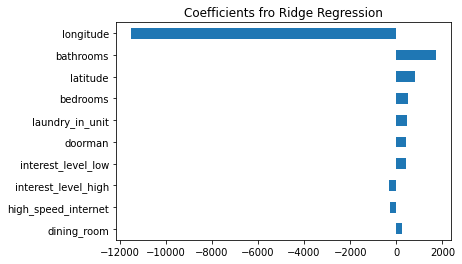

In [ ]:
coefficients = model_r.coef_
features = transformer_1.get_feature_names()
Features_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
Features_importance.tail(10).plot(kind='barh')
plt.title('Coefficients fro Ridge Regression');